In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip install -r requirements.txt

In [3]:
from google.cloud import storage
import pandas as pd
from tqdm.auto import tqdm
import plotly.express as px
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import os

In [4]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.timeseries import TimeGAN

2022-05-12 21:57:23.591574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [6]:
client = storage.Client()
BUCKET_NAME = 'gcp101227-sfpdemo-datasets'
bucket = client.get_bucket(BUCKET_NAME)
blobs = bucket.list_blobs()
csv_files = [file.name for file in blobs if '.csv' in file.name and 'hipe/clean' in file.name]
file_name = csv_files[0]
path_file = 'gs://' + BUCKET_NAME + '/' + file_name

In [7]:
from hipe_data_preparation import prepare_30s_resample

In [8]:
df = prepare_30s_resample()
df.head()

Read from cache: gs://gcp101227-sfpdemo-datasets/sample30sec.csv


SensorDateTime  ChipPress  ChipSaw  HighTemperatureOven  \
0 2017-09-30 22:00:00+00:00        0.0      0.0                  0.0   
1 2017-09-30 22:00:30+00:00        0.0      0.0                  0.0   
2 2017-09-30 22:01:00+00:00        0.0      0.0                  0.0   
3 2017-09-30 22:01:30+00:00        0.0      0.0                  0.0   
4 2017-09-30 22:02:00+00:00        0.0      0.0                  0.0   

   MainTerminal  PickAndPlaceUnit  ScreenPrinter  SolderingOven  VacuumOven  \
0      6.290000             -0.01            0.0            0.0         0.0   
1      6.292000             -0.01            0.0            0.0         0.0   
2      6.278333             -0.01            0.0            0.0         0.0   
3      7.190000             -0.01            0.0            0.0         0.0   
4      7.320000             -0.01            0.0            0.0         0.0   

   VacuumPump1  VacuumPump2  WashingMachine  
0          0.0          0.0            0.02  
1          0.0          0.0            0.02  
2          0.0          0.0            0.02  
3          0.0          0.0            0.02  
4          0.0          0.0            0.02

In [13]:
data = df[['SensorDateTime', 'MainTerminal']]

In [11]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val = train_test_split(data, train_size=.8, shuffle=False)

In [10]:
df.SensorDateTime.describe(datetime_is_numeric=True)

count                                 265080
mean     2017-11-15 22:29:44.999999744+00:00
min                2017-09-30 22:00:00+00:00
25%         2017-10-23 22:14:52.500000+00:00
50%                2017-11-15 22:29:45+00:00
75%         2017-12-08 22:44:37.500000+00:00
max                2017-12-31 22:59:30+00:00
Name: SensorDateTime, dtype: object

In [18]:
in_data = X_train.iloc[:, 1:]

In [19]:
from sklearn.impute import KNNImputer

In [20]:
scaler = MinMaxScaler()
imputer = KNNImputer()

In [21]:
def preprocess_data(df, scaler, imputer):
    imputed = imputer.fit_transform(df)
    scaled = scaler.fit_transform(imputed)
    return scaled

In [22]:
in_scaled = preprocess_data(in_data, scaler, imputer)

In [30]:
seq_len=64           # Sequence length
n_seq = 1            # Number of features in a sequence
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

train_steps = 500
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [31]:
import tensorflow as tf

def prepare_timegan_input(data: pd.DataFrame, seq_len:int):
    """TimeGAN from ydata_synthetic accepts a dataframe-like object of sequences.
    
    We use TF to create those sequences
    """
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(data, None, seq_len)
    collect = []
    for batch in tqdm(dataset):
        collect.append(batch)
    data = tf.concat(collect, 0)
    data = tf.cast(data, tf.float32)
    data = tf.random.shuffle(data)
    return data

In [32]:
tgan_input = prepare_timegan_input(in_scaled, seq_len)

  0%|          | 0/1657 [00:00<?, ?it/s]

In [33]:
tgan_input.shape

TensorShape([212001, 64, 1])

In [34]:
model_path = 'timegan_mainterminal_only.pkl'

In [35]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=gamma)

if os.path.exists(model_path):
    synth = synth.load(model_path)
else:
    synth.train(tgan_input, train_steps=train_steps)
    synth.save(model_path)

Joint networks training: 100%|██████████| 500/500 [26:39<00:00,  3.20s/it]


In [41]:
synth_data = synth.sample(len(X_val))
synth_data.shape

Synthetic data generation: 100%|██████████| 415/415 [03:03<00:00,  2.26it/s]


(53120, 64, 1)

In [42]:
def sequences_to_sequence(sequences):
    X, seq_len, Y = sequences.shape
    
    collect = [sequences[0, :], sequences[1:,-1,:]] # first sequence in entirety, others just the last element in seq
    concatenated = tf.concat(collect, 0)
    df = concatenated.numpy()
    return df

In [43]:
unnested_seq = sequences_to_sequence(synth_data)

In [44]:
def inverse_transformations(synth_data, scaler):
    return scaler.inverse_transform(synth_data)

In [45]:
transformed_seq = inverse_transformations(unnested_seq, scaler)

In [46]:
unscaled_seq = pd.DataFrame(transformed_seq, columns=in_data.columns)

In [47]:
unscaled_seq = unscaled_seq[:len(X_val)]

In [48]:
unscaled_seq.head()

MainTerminal
0     11.147849
1      5.803332
2      4.670112
3      5.392312
4      9.262943

In [50]:
unscaled_seq['SensorDateTime'] = X_val.reset_index().copy()['SensorDateTime']

In [116]:
before = X_train.copy()
before['label'] = 'history'

after = X_val.copy()
after['label'] = 'future'
unscaled_seq['label'] = 'synth'
out_df = pd.concat([before, after, unscaled_seq], ignore_index=True)

In [117]:
out_df.head()

SensorDateTime  MainTerminal    label
0 2017-09-30 22:00:00+00:00      6.290000  history
1 2017-09-30 22:00:30+00:00      6.292000  history
2 2017-09-30 22:01:00+00:00      6.278333  history
3 2017-09-30 22:01:30+00:00      7.190000  history
4 2017-09-30 22:02:00+00:00      7.320000  history

In [118]:
ts_col = 'SensorDateTime'

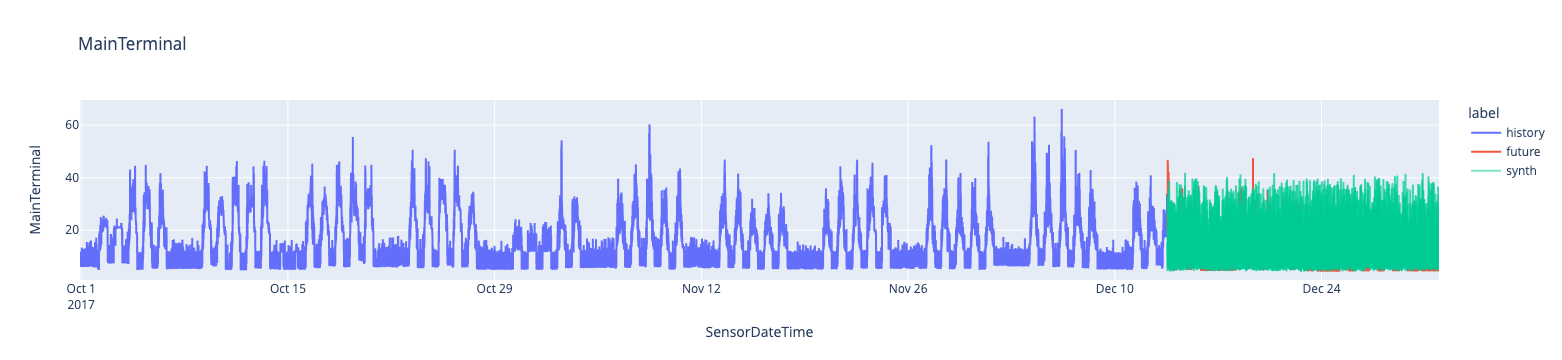

In [121]:
for c in out_df.columns:
    if c == ts_col or c == 'label':
        continue
    fig = px.line(out_df.iloc[::10,:], x=ts_col, y=c, color='label', title=c)
    for trace in fig.data:
        if trace['legendgroup'] == 'synth':
            trace['opacity'] = 0.5
    fig.show()

In [141]:
X = np.cos(np.arange(0, 5000, 0.05) / 100)

In [142]:
X_df = pd.Series(X, name='cos').to_frame()

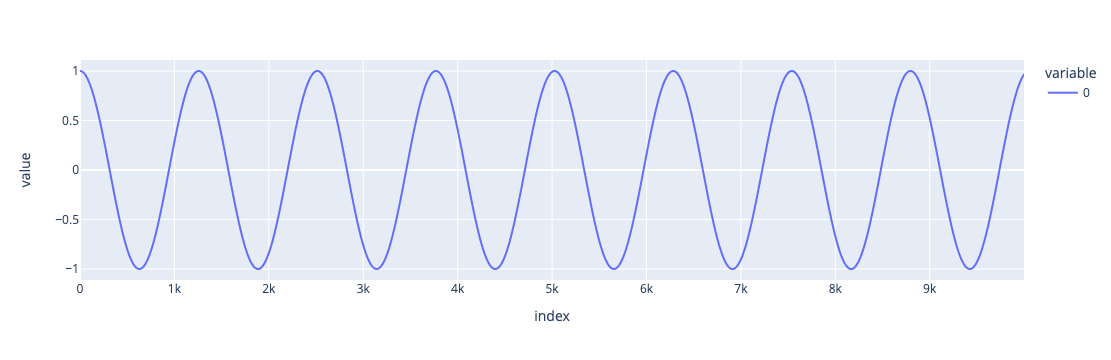

In [134]:
px.line(X[::10])

In [135]:
seq_len=32           # Sequence length
n_seq = 1            # Number of features in a sequence
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

train_steps = 300
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [136]:
model_path = 'timegan_cos.pkl'

In [144]:
tgan_input = prepare_timegan_input(X_df, seq_len)

  0%|          | 0/782 [00:00<?, ?it/s]

In [146]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=gamma)

if os.path.exists(model_path):
    synth = synth.load(model_path)
else:
    synth.train(tgan_input, train_steps=train_steps)
    synth.save(model_path)

Joint networks training: 100%|██████████| 300/300 [14:41<00:00,  2.94s/it]


In [ ]:
synth_data = synth.sample(200)
synth_data.shape

In [ ]:
synth_data.shape

In [192]:
def sequences_to_sequence(sequences):
    X, seq_len, Y = sequences.shape
    
    collect = [sequences[i, 0] for i in range(10000)] # first sequence in entirety, others just the last element in seq
    concatenated = tf.concat(collect, 0)
    df = concatenated.numpy()
    return df

In [193]:
unnested_seq = sequences_to_sequence(synth_data)

In [194]:
unscaled_seq = pd.DataFrame(unnested_seq, columns=['cos'])

In [195]:
unscaled_seq = unscaled_seq[:len(X_val)]

In [196]:
unscaled_seq.head()

cos
0  0.113146
1  0.117725
2  0.116416
3  0.098949
4  0.147944

In [197]:
before = X_df.copy()
before['label'] = 'history'

unscaled_seq['label'] = 'synth'
out_df = pd.concat([before, unscaled_seq], ignore_index=True)

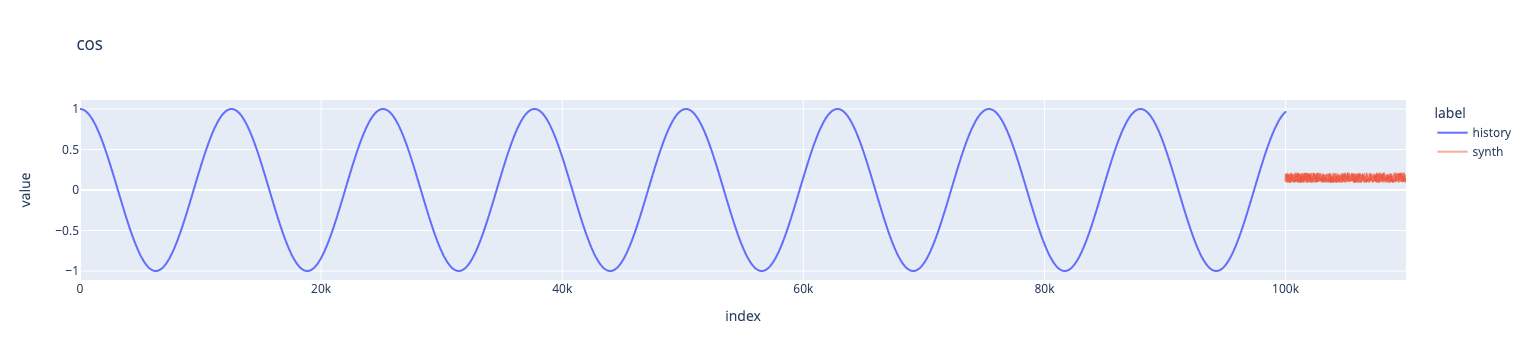

In [198]:
for c in out_df.columns:
    if c == ts_col or c == 'label':
        continue
    fig = px.line(out_df.iloc[::10,:],color='label', title=c)
    for trace in fig.data:
        if trace['legendgroup'] == 'synth':
            trace['opacity'] = 0.5
    fig.show()